In [1]:
# (Cell đầu tiên - nếu bạn chưa có)
!pip install tensorflowjs joblib kagglehub
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nasirayub2/human-vital-sign-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'human-vital-sign-dataset' dataset.
Path to dataset files: /kaggle/input/human-vital-sign-dataset


In [ ]:
# Import các thư viện cần thiết
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# --- 1. ĐỌC DỮ LIỆU ---
# Biến 'path' đã có từ cell trước của bạn
# 'path' là đường dẫn đến thư mục đã giải nén
file_path = os.path.join(path, 'human_vital_signs_dataset_2024.csv')

try:
    df = pd.read_csv(file_path)
    print("Đã tải dữ liệu Vitals vào DataFrame thành công.")
except Exception as e:
    print(f"LỖI: Không thể đọc file. {e}")

# --- 2. TIỀN XỬ LÝ (THEO YÊU CẦU) ---

# --- 2.1. Mã hóa (Encode) 'Gender' TRƯỚC ---
# Chuyển 'Male'/'Female' thành 0/1
gender_encoder = LabelEncoder()
df['Gender_encoded'] = gender_encoder.fit_transform(df['Gender'])
print("\nĐã mã hóa 'Gender' (ví dụ: Female=0, Male=1):")
print(df[['Gender', 'Gender_encoded']].head())

# --- 2.2. Định nghĩa các nhóm Features ---
# (Sử dụng tên cột chính xác từ file CSV)
time_series_features = [
    'Oxygen Saturation', # SpO2
    'Body Temperature',  # Thân nhiệt
    'Heart Rate', # Nhịp tim
    'Derived_MAP'
]
n_ts_features = len(time_series_features)

static_features = [
    'Age',
    'Weight (kg)',
    'Height (m)',
    'Derived_BMI',
    'Gender_encoded'  # <-- ĐÃ THÊM VÀO ĐÂY
]
n_static_features = len(static_features) # Bây giờ sẽ là 5

# --- 2.3. Xử lý Dữ liệu ---
# ⚠️ QUAN TRỌNG: KHÔNG SCALE Ở ĐÂY! Sẽ scale ở Cell 3 với scaler_mlp

# Mã hóa (Encode) Nhãn Target
risk_encoder = LabelEncoder()
df['RiskLevel_encoded'] = risk_encoder.fit_transform(df['Risk Category'])
n_classes_vitals = len(df['RiskLevel_encoded'].unique())

print(f"\nSố lượng Feature Time-Series: {n_ts_features}")
print(f"Số lượng Feature Tĩnh: {n_static_features}") # Sẽ cập nhật thành 5
print(f"Số lượng Lớp (Classes): {n_classes_vitals} (Bài toán nhị phân)")
print("\nDataFrame sau khi xử lý:")
print(df.head())

# --- THÊM CODE EXPORT DƯỚI ĐÂY ---
import joblib
import json
print("\n--- BẮT ĐẦU EXPORT ENCODER ---")

# 1. Lưu file .pkl
joblib.dump(risk_encoder, 'risk_encoder.pkl')
print("ĐÃ LƯU 'risk_encoder.pkl' THÀNH CÔNG!")

# 2. Export file .json cho Node.js
encoder_params = {
    'classes': risk_encoder.classes_.tolist()
}
with open('risk_encoder.json', 'w') as f:
    json.dump(encoder_params, f)
print("Đã export 'risk_encoder.json' THÀNH CÔNG!")
# --- KẾT THÚC THÊM CODE ---


Đã tải dữ liệu Vitals vào DataFrame thành công.

Đã mã hóa 'Gender' (ví dụ: Female=0, Male=1):
   Gender  Gender_encoded
0  Female               0
1    Male               1
2  Female               0
3  Female               0
4  Female               0

Số lượng Feature Time-Series: 4
Số lượng Feature Tĩnh: 5
Số lượng Lớp (Classes): 2 (Bài toán nhị phân)

DataFrame sau khi xử lý:
   Patient ID  Heart Rate  Respiratory Rate                   Timestamp  \
0           1   -1.690814                12  2024-07-19 21:53:45.729841   
1           2   -1.431138                18  2024-07-19 21:52:45.729841   
2           3   -1.431138                15  2024-07-19 21:51:45.729841   
3           4    1.684972                16  2024-07-19 21:50:45.729841   
4           5   -0.911787                16  2024-07-19 21:49:45.729841   

   Body Temperature  Oxygen Saturation  Systolic Blood Pressure  \
0          0.261613          -1.249365                      124   
1         -0.546333          -0.56

In [ ]:
# --- 3. CHUẨN HÓA (SCALING) VÀ EXPORT ---
import joblib
import json

# Gộp tất cả các features bạn đã chọn lại
all_features = time_series_features + static_features
n_features_total = len(all_features)

print(f"Tổng số features sẽ sử dụng: {n_features_total}")
print(f"Danh sách features: {all_features}")

# ✅ LẤY DỮ LIỆU RAW (CHƯA SCALE) từ DataFrame gốc
X_data_raw = df[all_features].values
y_data = df['RiskLevel_encoded'].values

# Kiểm tra giá trị raw data
print(f"\n📊 Sample RAW data (first row):")
print(f"   SpO2: {X_data_raw[0][0]:.2f}")
print(f"   Temp: {X_data_raw[0][1]:.2f}")
print(f"   HR: {X_data_raw[0][2]:.2f}")
print(f"   MAP: {X_data_raw[0][3]:.2f}")

# Fit scaler trên RAW DATA
scaler_mlp = StandardScaler()
scaler_mlp.fit(X_data_raw)
print(f"\n✅ Đã fit 'scaler_mlp' trên {n_features_total} features (RAW DATA).")

# Kiểm tra scaler values
print(f"\n📏 Scaler Statistics:")
print(f"   Mean[0] (SpO2): {scaler_mlp.mean_[0]:.2f} (phải ~95-98)")
print(f"   Mean[1] (Temp): {scaler_mlp.mean_[1]:.2f} (phải ~36-37)")
print(f"   Scale[0] (SpO2): {scaler_mlp.scale_[0]:.2f} (phải > 1)")
print(f"   Scale[1] (Temp): {scaler_mlp.scale_[1]:.2f} (phải > 0.5)")

# --- EXPORT SCALER NGAY TẠI ĐÂY ---
# 1. Lưu file .pkl
joblib.dump(scaler_mlp, 'scaler_mlp.pkl')
print("\n✅ ĐÃ LƯU 'scaler_mlp.pkl' THÀNH CÔNG!")

# 2. Export file .json cho Node.js
scaler_params_mlp = {
    'mean': scaler_mlp.mean_.tolist(),
    'scale': scaler_mlp.scale_.tolist()
}
with open('scaler_mlp.json', 'w') as f:
    json.dump(scaler_params_mlp, f, indent=2)
print("✅ Đã export 'scaler_mlp.json' THÀNH CÔNG!")

# --- 3.2. TẠO DỮ LIỆU TRAINING ---
# Bây giờ mới áp dụng .transform()
X_data = scaler_mlp.transform(X_data_raw)
print(f"\n✅ Đã tạo xong dữ liệu X, y đã chuẩn hóa:")
print(f"   Shape của X: {X_data.shape}")
print(f"   Shape của y: {y_data.shape}")
print(f"   Sample scaled data (first row): {X_data[0][:3]}")


Tổng số features sẽ sử dụng: 9
Danh sách features: ['Oxygen Saturation', 'Body Temperature', 'Heart Rate', 'Derived_MAP', 'Age', 'Weight (kg)', 'Height (m)', 'Derived_BMI', 'Gender_encoded']

Đã tạo xong dữ liệu X, y:
Shape của X: (200020, 9)
Shape của y: (200020,)
Tổng số features sẽ sử dụng: 9
Danh sách features: ['Oxygen Saturation', 'Body Temperature', 'Heart Rate', 'Derived_MAP', 'Age', 'Weight (kg)', 'Height (m)', 'Derived_BMI', 'Gender_encoded']

Đã fit 'scaler_mlp' trên 9 features thành công.
ĐÃ LƯU 'scaler_mlp.pkl' THÀNH CÔNG!
Đã export 'scaler_mlp.json' THÀNH CÔNG!

Đã tạo xong dữ liệu X, y đã chuẩn hóa:
Shape của X: (200020, 9)
Shape của y: (200020,)


In [14]:
# --- 4. CHIA DỮ LIỆU (MỚI) ---
print("Đang chia dữ liệu...")

# Chia 80% Train/Val - 20% Test
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_data, y_data,
    test_size=0.20,
    random_state=42,
    stratify=y_data
)

# Chia 80% Train - 20% Val
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val,
    test_size=0.20,
    random_state=42,
    stratify=y_train_val
)

print(f"Training shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Validation shapes: X={X_val.shape}, y={y_val.shape}")
print(f"Test shapes: X={X_test.shape}, y={y_test.shape}")
print("\n--- CHIA DỮ LIỆU HOÀN TẤT ---")

Đang chia dữ liệu...
Training shapes: X=(128012, 9), y=(128012,)
Validation shapes: X=(32004, 9), y=(32004,)
Test shapes: X=(40004, 9), y=(40004,)

--- CHIA DỮ LIỆU HOÀN TẤT ---


In [17]:
# --- 5. XÂY DỰNG MÔ HÌNH (MLP - TỐI ƯU CHO DỮ LIỆU BẢNG) ---

# --- THÊM CÁC IMPORT BỊ THIẾU ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
import tensorflow as tf
# --- KẾT THÚC THÊM IMPORT ---

print("Đang xây dựng kiến trúc mô hình MLP (cho dữ liệu bảng)...")

n_features_total = X_data.shape[1] # Tổng số features (ví dụ: 7)

# Dùng Sequential vì mô hình giờ đã đơn giản
model_mlp = Sequential(name="MLP_Vitals_Model_Binary")

# Input layer (khai báo shape đầu vào)
model_mlp.add(Input(shape=(n_features_total,), name='All_Features_Input'))

# Lớp ẩn 1
model_mlp.add(Dense(units=64, activation='relu'))
model_mlp.add(BatchNormalization())
model_mlp.add(Dropout(0.3))

# Lớp ẩn 2
model_mlp.add(Dense(units=64, activation='relu'))
model_mlp.add(BatchNormalization())
model_mlp.add(Dropout(0.3))

# Lớp ẩn 3
model_mlp.add(Dense(units=32, activation='relu'))
model_mlp.add(BatchNormalization())
model_mlp.add(Dropout(0.3))

# Lớp Output (1 nơ-ron, 'sigmoid' cho 2 lớp)
model_mlp.add(Dense(1, activation='sigmoid', name='Risk_Output'))

model_mlp.summary()

# --- BIÊN DỊCH (COMPILE) ---
model_mlp.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print("\n--- XÂY DỰNG VÀ BIÊN DỊCH MÔ HÌNH MLP HOÀN TẤT ---")

Đang xây dựng kiến trúc mô hình MLP (cho dữ liệu bảng)...


Model: "MLP_Vitals_Model_Binary"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Risk_Output (Dense)             │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,553 (29.50 KB)

 Trainable params: 7,233 (28.25 KB)

 Non-trainable params: 320 (1.25 KB)


--- XÂY DỰNG VÀ BIÊN DỊCH MÔ HÌNH MLP HOÀN TẤT ---


In [18]:
# --- 6. HUẤN LUYỆN MÔ HÌNH (MLP) ---

# Thiết lập Callbacks
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    verbose=1,
    mode='max',
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    verbose=1,
    min_lr=1e-6,
    mode='min'
)

# Huấn luyện
EPOCHS = 100
BATCH_SIZE = 64

print("\n--- BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH MLP ---")

history = model_mlp.fit(
    X_train, # Chỉ cần truyền X_train (đã được tạo ở Cell 4)
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(
        X_val, # Chỉ cần truyền X_val
        y_val
    ),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

print("\n--- HUẤN LUYỆN HOÀN TẤT ---")


--- BẮT ĐẦU HUẤN LUYỆN MÔ HÌNH MLP ---
Epoch 1/100
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.8447 - loss: 0.3307 - val_accuracy: 0.9904 - val_loss: 0.0339 - learning_rate: 0.0010
Epoch 2/100
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9661 - loss: 0.0889 - val_accuracy: 0.9928 - val_loss: 0.0215 - learning_rate: 0.0010
Epoch 3/100
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9777 - loss: 0.0627 - val_accuracy: 0.9940 - val_loss: 0.0167 - learning_rate: 0.0010
Epoch 4/100
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9819 - loss: 0.0524 - val_accuracy: 0.9956 - val_loss: 0.0134 - learning_rate: 0.0010
Epoch 5/100
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9838 - loss: 0.0471 - val_accuracy: 0.9916 - val_loss: 0.0213 - learning_rate: 0.0010
Epoch 6/100
2001/2001 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.9854 - loss: 0.0408 - val_accuracy: 0.9912 - val_loss: 0.0218 - learning_rate: 0.0010
Epoch 7/100
2001/2001 ━━━━━━━


--- ĐÁNH GIÁ MÔ HÌNH MLP TRÊN TẬP TEST ---
Test Loss: 0.0042
Test Accuracy: 0.9981 (Đây là độ chính xác cuối cùng)
1251/1251 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Báo cáo Phân loại (Classification Report):
              precision    recall  f1-score   support

   High Risk       1.00      1.00      1.00     21023
    Low Risk       1.00      1.00      1.00     18981

    accuracy                           1.00     40004
   macro avg       1.00      1.00      1.00     40004
weighted avg       1.00      1.00      1.00     40004

Đang vẽ Ma trận Nhầm lẫn (Confusion Matrix)...


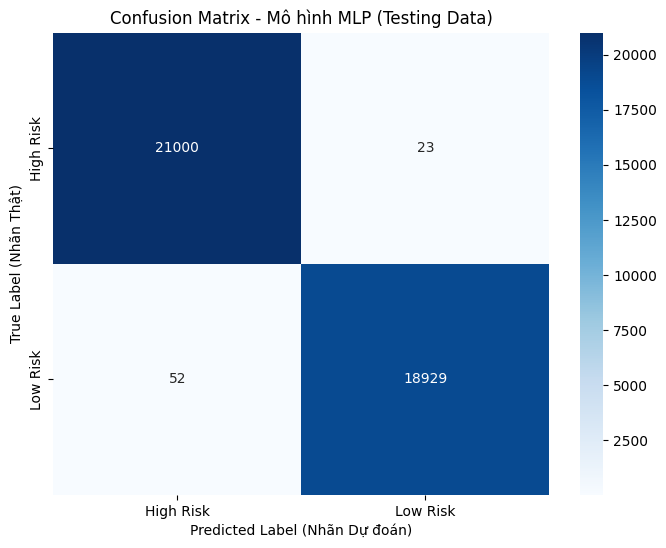

In [19]:
# --- 7. ĐÁNH GIÁ KẾT QUẢ (MLP) ---
print("\n--- ĐÁNH GIÁ MÔ HÌNH MLP TRÊN TẬP TEST ---")

test_loss, test_accuracy = model_mlp.evaluate(
    X_test,
    y_test,
    verbose=0
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f} (Đây là độ chính xác cuối cùng)")

# Lấy xác suất dự đoán
y_pred_probs = model_mlp.predict(X_test)
# Chuyển xác suất thành nhãn 0 hoặc 1
y_pred = (y_pred_probs > 0.5).astype("int32").flatten()

# Lấy tên nhãn gốc ('High Risk', 'Low Risk')
target_names = risk_encoder.classes_
print("\nBáo cáo Phân loại (Classification Report):")
print(classification_report(y_test, y_pred, target_names=target_names))

# Vẽ ma trận nhầm lẫn
print("Đang vẽ Ma trận Nhầm lẫn (Confusion Matrix)...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix - Mô hình MLP (Testing Data)')
plt.ylabel('True Label (Nhãn Thật)')
plt.xlabel('Predicted Label (Nhãn Dự đoán)')
plt.show()

In [8]:
from google.colab import drive
drive.mount('/content/drive')

KeyboardInterrupt: 

In [20]:
# --- 8. LƯU VÀ EXPORT MÔ HÌNH (SỬA LỖI KERAS 3) ---
import os

print("\n--- BẮT ĐẦU EXPORT MODEL ---")

# 1. Lưu dạng SavedModel (Chuẩn tương thích nhất cho Keras 3 -> TFJS)
# model.export() sẽ tạo ra một thư mục chứa model chuẩn TensorFlow
export_dir = 'saved_model_mlp'
model_mlp.export(export_dir)
print(f"Đã export model sang thư mục '{export_dir}' (SavedModel format) THÀNH CÔNG!")

# 2. Convert từ SavedModel sang TF.js
# Lưu ý: Dùng input_format=tf_saved_model thay vì keras
output_dir = 'tfjs_mlp_model'
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    {export_dir} \
    {output_dir}

print(f"Đã convert sang thư mục '{output_dir}' THÀNH CÔNG!")

print("\n--- HOÀN TẤT TẤT CẢ ---")
print("Bạn có thể tải về 3 mục:")
print(f"1. Thư mục '{output_dir}' (Zip thư mục này lại để tải)")
print("2. File 'scaler_mlp.json'")
print("3. File 'risk_encoder.json'")


--- BẮT ĐẦU EXPORT MODEL ---
Saved artifact at 'saved_model_mlp'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 9), dtype=tf.float32, name='All_Features_Input')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  138354599850640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138354599851984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138354599848720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138354599853136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138354599851792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138354599852752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138355238831120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138355238832272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138355238833424: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138355238833808: TensorSpec(shape=(), dtype=tf.resource, na

In [21]:
import shutil
import os

folder_to_zip = "tfjs_mlp_model"
zip_name = "tfjs_mlp_model"  # sẽ tạo ra tfjs_mlp_model.zip

if os.path.exists(folder_to_zip):
    shutil.make_archive(zip_name, 'zip', folder_to_zip)
    print("Đã tạo file 'tfjs_mlp_model.zip' THÀNH CÔNG!")
else:
    print("Không tìm thấy thư mục tfjs_mlp_model")


Đã tạo file 'tfjs_mlp_model.zip' THÀNH CÔNG!
